<a href="https://colab.research.google.com/github/DiabeticRetinopathy114/114_DR/blob/main/224x224%20Gaussian%20Filtered/Resnet50/70%2015%2015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/export.pkl
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/f481f76a6b75.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/abdb365cacbc.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/33ffddea8c6e.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/278aa860dffd.png
/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/d66b6f333dc7.png
/kaggle/i

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
!pip install imutils
from imutils import paths
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
!ls -R /kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered | head -n 50


/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered:
gaussian_filtered_images
train.csv

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images:
gaussian_filtered_images

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images:
export.pkl
Mild
Moderate
No_DR
Proliferate_DR
Severe

/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild:
0024cdab0c1e.png
00cb6555d108.png
0124dffecf29.png
01b3aed3ed4c.png
0369f3efe69b.png
03e25101e8e8.png
04ac765f91a1.png
059bc89df7f4.png
05a5183c92d0.png
0684311afdfc.png
06b71823f9cd.png
07929d32b5b3.png
07a1c7073982.png
086d41d17da8.png
09935d72892b.png
0a3202889f4d.png
0a61bddab956.png
0ad7f631dedb.png
0d310aba6373.png
0dc031c94225.png
0dce95217626.png
0eb52045349f.png
0f495d87656a.png
0fb1053285cf.png
101b9ebfc720.png
107aea0d9289.png
10f36b0239fb.png
1116271db4ea.png
111898ab463d.png
12ce6a1a1f31.

In [ ]:


# 圖片根目錄（已確認）
image_root = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images"

# 讀取 CSV
df = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv")

# 對應診斷分類
diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

# 新增 type 欄位（分類資料夾名稱）
df["type"] = df["diagnosis"].map(diagnosis_classes)

# 建立圖片完整路徑
df["image_path"] = df.apply(
    lambda row: os.path.join(image_root, row["type"], f"{row['id_code']}.png"),
    axis=1
)

# 確認圖片是否存在
df["file_exists"] = df["image_path"].apply(os.path.exists)

# 統計結果
missing = df[~df["file_exists"]]
print(f"✅ 成功找到圖片數量：{df['file_exists'].sum()}")
print(f"❌ 找不到圖片數量：{len(missing)}")
print("❌ 範例：", missing["image_path"].head().tolist())


✅ 成功找到圖片數量：3662
❌ 找不到圖片數量：0
❌ 範例： []


In [ ]:
df.head()

,id_code,diagnosis,type,image_path,file_exists
0,000c1434d8d7,2,Moderate,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
1,001639a390f0,4,Proliferate_DR,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
2,0024cdab0c1e,1,Mild,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
3,002c21358ce6,0,No_DR,/kaggle/input/diabetic-retinopathy-224x224-gau...,True
4,005b95c28852,0,No_DR,/kaggle/input/diabetic-retinopathy-224x224-gau...,True


<Axes: ylabel='type'>

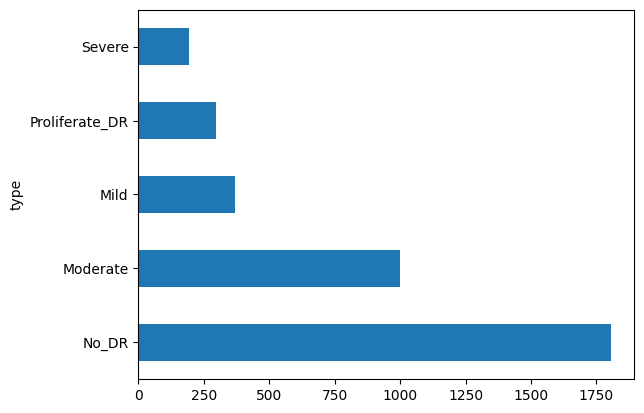

In [ ]:
df['type'].value_counts().plot(kind='barh')

In [ ]:

# 1. 將 diagnosis 欄位轉為分類標籤（字串）
df['binary'] = df['diagnosis'].apply(lambda x: 'no_DR' if x == 0 else 'DR')

# 2. 將字串標籤轉成整數 0/1，才能與 binary_crossentropy 搭配
df['binary_label'] = df['binary'].map({'no_DR': 0, 'DR': 1})

# 3. 額外字串標籤（如果你後面要四分類會用到）
df['str_label'] = df['type'].astype(str)


<Axes: ylabel='binary'>

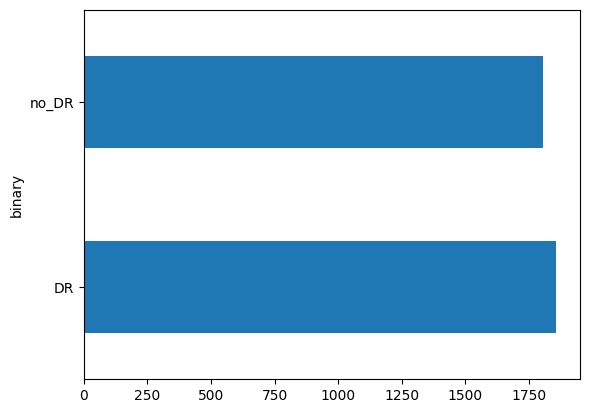

In [ ]:

df['binary'].value_counts().plot(kind='barh')

In [ ]:
# 拆分成兩個資料集
df_stage1 = df.copy()
df_stage2 = df[df['diagnosis'] != 0].copy()
df_stage2['stage2_label'] = df_stage2['diagnosis'] - 1
df_stage2['image_path'] = df_stage2.apply(lambda row: f"{row['type']}/{row['id_code']}.png", axis=1)  # 將 1~4 → 0~3（方便分類）

In [ ]:
# --- Stage 1: 無DR vs 有DR（二元分類） ---
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 先過濾有效路徑
df_valid = df[df["file_exists"]]

# 第一步：train 70%、剩下 30%
train_df, temp_df = train_test_split(df_valid, test_size=0.3, random_state=42, stratify=df_valid["binary"])

# 第二步：從剩下的 30% 中，再切成 val/test 各 15%
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["binary"])

# 建立 ImageDataGenerator（這裡就不需要 validation_split）
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

# val/test 不做 data augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='binary_label',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42
)

# Validation generator
val_gen = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='binary_label',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

# Test generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='binary_label',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 2563 validated image filenames.
Found 549 validated image filenames.
Found 550 validated image filenames.


In [ ]:
import os
import shutil

src_root = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

diagnosis_dict = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}

dst_root = 'train_stage2'
if os.path.exists(dst_root):
    shutil.rmtree(dst_root)
os.makedirs(dst_root)

for _, row in df_stage2.iterrows():
    diagnosis_level = row['diagnosis']  # 整數 0~4
    if diagnosis_level == 0:
        continue  # 跳過 No_DR

    class_folder = str(diagnosis_level - 1)  # 對應 1~4 → 0~3
    filename = row['id_code'] + '.png'
    folder_name = diagnosis_dict[diagnosis_level]

    srcfile = os.path.join(src_root, folder_name, filename)
    dst_dir = os.path.join(dst_root, class_folder)
    os.makedirs(dst_dir, exist_ok=True)

    if os.path.exists(srcfile):
        shutil.copy(srcfile, dst_dir)
    else:
        print(f'❌ 找不到圖片：{srcfile}')


In [ ]:
# 1. 先檢查數據分佈
print("=== 檢查 Stage 2 數據分佈 ===")
stage2_class_counts = {}
total_stage2 = 0
for i in range(4):
    class_path = os.path.join('train_stage2', str(i))
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        stage2_class_counts[i] = count
        total_stage2 += count
        print(f"類別 {i} (對應診斷等級 {i+1}): {count} 張")
    else:
        print(f"類別 {i}: 資料夾不存在")
        stage2_class_counts[i] = 0

print(f"Stage 2 總圖片數: {total_stage2}")

=== 檢查 Stage 2 數據分佈 ===
類別 0 (對應診斷等級 1): 370 張
類別 1 (對應診斷等級 2): 999 張
類別 2 (對應診斷等級 3): 193 張
類別 3 (對應診斷等級 4): 295 張
Stage 2 總圖片數: 1857


Stage 2: 多分類（4類）

In [ ]:

import os, shutil
from sklearn.model_selection import train_test_split

# 原始資料資料夾
src_dir = 'train_stage2'
# 目標資料夾
base_dir = 'split_stage2'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# 建立資料夾結構
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)
    for class_name in os.listdir(src_dir):
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

# 分類切分圖片
for class_name in os.listdir(src_dir):
    class_path = os.path.join(src_dir, class_name)
    images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


In [ ]:

# Training 用 augmentation
train_datagen_stage2 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen_stage2 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_stage2 = train_datagen_stage2.flow_from_directory(
    'split_stage2/train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='sparse',
    #class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen_stage2 = test_datagen_stage2.flow_from_directory(
    'split_stage2/val',
    target_size=(224, 224),
    batch_size=8,
    class_mode='sparse',
    #class_mode='categorical',
    shuffle=False
)

test_gen_stage2 = test_datagen_stage2.flow_from_directory(
    'split_stage2/test',
    target_size=(224, 224),
    batch_size=8,
    class_mode='sparse',
    #class_mode='categorical',
    shuffle=False
)


Found 1299 images belonging to 4 classes.
Found 278 images belonging to 4 classes.
Found 280 images belonging to 4 classes.


In [ ]:
print(df[['diagnosis', 'binary', 'binary_label']].head())


   diagnosis binary  binary_label
0          2     DR             1
1          4     DR             1
2          1     DR             1
3          0  no_DR             0
4          0  no_DR             0


In [ ]:
def create_resnet_model(output_classes, input_shape=(224, 224, 3), freeze_base=True):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    if freeze_base:
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        for layer in base_model.layers[-20:]:
            layer.trainable = True
    else:
        base_model.trainable = True  # 全部解凍
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [ ]:

# 建立 Stage 1 的模型
model_stage1 = create_resnet_model(output_classes=1, freeze_base=True)
callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    #ModelCheckpoint('best_model_stage1.h5', monitor='val_loss', save_best_only=True)
]

model_stage1.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 顯示模型結構
#model_stage1.summary()

In [ ]:

history_stage1 = model_stage1.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=callbacks_stage1,
    epochs=50,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 547ms/step - accuracy: 0.8068 - loss: 0.5746 - val_accuracy: 0.9545 - val_loss: 0.3337 - learning_rate: 5.0000e-05
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 405ms/step - accuracy: 0.9329 - loss: 0.3169 - val_accuracy: 0.9508 - val_loss: 0.2650 - learning_rate: 5.0000e-05
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 407ms/step - accuracy: 0.9331 - loss: 0.3278 - val_accuracy: 0.9472 - val_loss: 0.2471 - learning_rate: 5.0000e-05
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 400ms/step - accuracy: 0.9504 - loss: 0.2545 - val_accuracy: 0.9672 - val_loss: 0.2331 - learning_rate: 5.0000e-05
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 393ms/step - accuracy: 0.9545 - loss: 0.2397 - val_accuracy: 0.9690 - val_loss: 0.2302 - learning_rate: 5.0000e-05
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 393ms/step - accuracy: 0.9583 - loss: 0.2392 - val_accuracy: 0.9690 - val_loss: 0.2299 - learning_rate: 5.0000e-05
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 395ms/step - acc

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step
              precision    recall  f1-score   support

       No_DR       0.97      0.97      0.97       271
          DR       0.97      0.97      0.97       278

    accuracy                           0.97       549
   macro avg       0.97      0.97      0.97       549
weighted avg       0.97      0.97      0.97       549



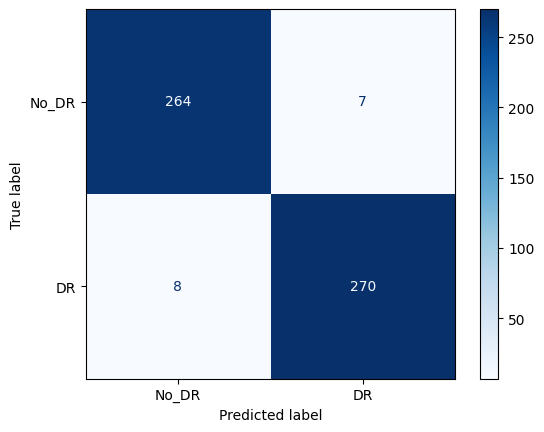

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 預測驗證集
val_gen.reset()
y_pred = model_stage1.predict(val_gen, verbose=1)

# 二元分類轉為 0/1
y_pred_bin = (y_pred > 0.5).astype(int).flatten()

# 真實標籤（從 val_df 拿）
y_true = val_df['binary_label'].values

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No_DR', 'DR'])
disp.plot(cmap='Blues')

# 分類報告
report = classification_report(y_true, y_pred_bin, target_names=['No_DR', 'DR'])
print(report)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step


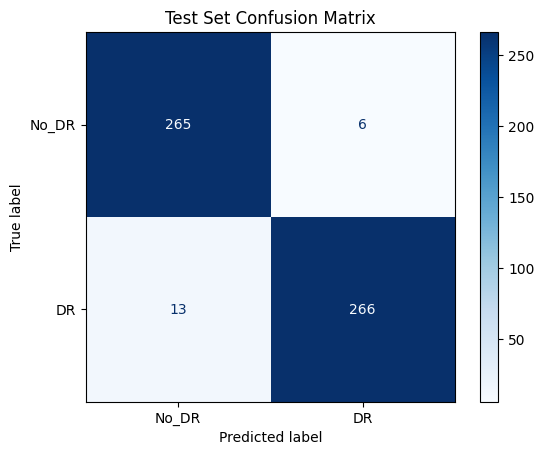

              precision    recall  f1-score   support

       No_DR       0.95      0.98      0.97       271
          DR       0.98      0.95      0.97       279

    accuracy                           0.97       550
   macro avg       0.97      0.97      0.97       550
weighted avg       0.97      0.97      0.97       550



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 預測測試集
test_gen.reset()
y_pred_test = model_stage1.predict(test_gen, verbose=1)

# 二元分類閾值轉為 0/1
y_pred_test_bin = (y_pred_test > 0.5).astype(int).flatten()

# 測試集真實標籤（從 test_df 取得）
y_true_test = test_df['binary_label'].values

# 計算混淆矩陣
cm_test = confusion_matrix(y_true_test, y_pred_test_bin)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No_DR', 'DR'])

# 繪圖
disp_test.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.show()

# 分類報告
report_test = classification_report(y_true_test, y_pred_test_bin, target_names=['No_DR', 'DR'])
print(report_test)


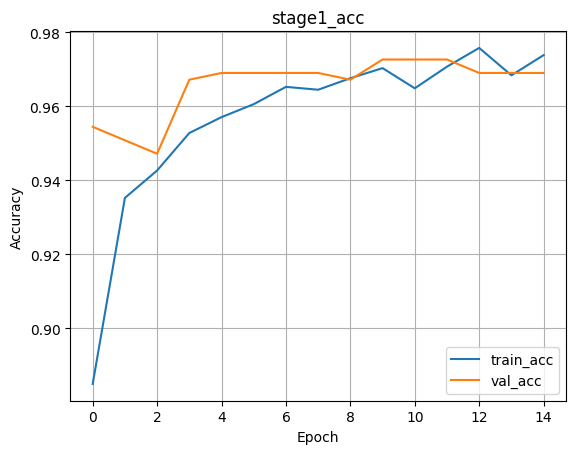

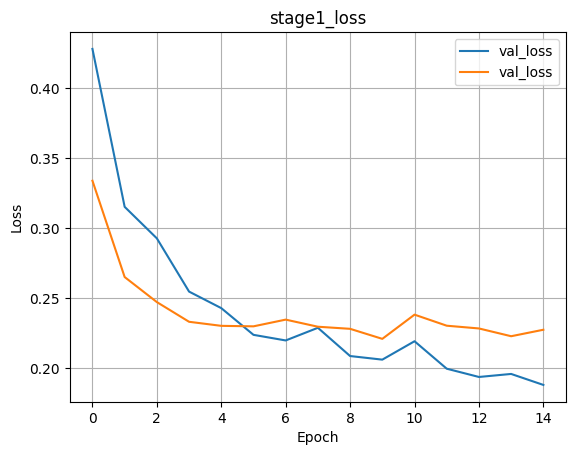

In [ ]:
import matplotlib.pyplot as plt

# 準確率
plt.plot(history_stage1.history['accuracy'], label='train_acc')
plt.plot(history_stage1.history['val_accuracy'], label='val_acc')
plt.title('stage1_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 損失
plt.plot(history_stage1.history['loss'], label='val_loss')
plt.plot(history_stage1.history['val_loss'], label='val_loss')
plt.title('stage1_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**第二階段模型（多分類 4 類）**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight



In [ ]:
print(type(train_gen_stage2))


<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>


In [ ]:
from sklearn.utils import class_weight

# 建立模型
def create_stage2_model(output_classes=4, input_shape=(224, 224, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # 凍結基底網路

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(output_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# 從 train generator 取出所有類別標籤
y_train_stage2 = train_gen_stage2.classes  # 對應 0 ~ 3 的整數標籤

# 類別總數
n_classes = np.unique(y_train_stage2)

# 計算權重
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=n_classes,
    y=y_train_stage2
)
# 將權重進行平滑處理，避免過於極端
smooth_factor = 0.5
class_weights_smooth = {}
for i, w in enumerate(class_weights_array):
    class_weights_smooth[i] = 1 + (w - 1) * smooth_factor

print("平滑後的權重:", class_weights_smooth)
# 轉成 list 傳給 focal loss 的 alpha
alpha = list(class_weights_smooth.values()) # 更正這裡

print("用於 focal loss 的 alpha:", alpha)

# 建立模型
model_stage2 = create_stage2_model(output_classes=4)


for layer in model_stage2.layers:
    layer.trainable = False

for i in range(-5, 0):
    model_stage2.layers[i].trainable = True

# 顯示模型結構
model_stage2.summary()

平滑後的權重: {0: 1.1269305019305018, 1: 0.7322961373390557, 2: 1.7027777777777777, 3: 1.2882281553398058}
用於 focal loss 的 alpha: [1.1269305019305018, 0.7322961373390557, 1.7027777777777777, 1.2882281553398058]


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 29,894,532 (114.04 MB)

 Trainable params: 6,298,628 (24.03 MB)

 Non-trainable params: 23,595,904 (90.01 MB)

In [ ]:
# 自訂多類別 focal loss
def focal_loss_multiclass(gamma=1.5, alpha=None):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])  # one-hot
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)  # 避免log(0)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = tf.pow(1 - y_pred, gamma)

        if alpha is not None:
            alpha_t = tf.constant(alpha, dtype=tf.float32)
            alpha_t = tf.reshape(alpha_t, [1, -1])
            weights = weights * alpha_t

        loss = weights * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss

In [ ]:
# 編譯模型
model_stage2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss_multiclass(gamma=2.0, alpha=alpha),
    metrics=['accuracy']
)
history1_stage2 = model_stage2.fit(
        train_gen_stage2,
        validation_data=val_gen_stage2,
        epochs=10,
        verbose=1
    )

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.3535 - loss: 1.2022 - val_accuracy: 0.2662 - val_loss: 0.7757
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.3992 - loss: 0.9450 - val_accuracy: 0.4388 - val_loss: 0.6699
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.3986 - loss: 0.8547 - val_accuracy: 0.2482 - val_loss: 0.7215
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.4568 - loss: 0.7146 - val_accuracy: 0.3309 - val_loss: 0.6759
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.4395 - loss: 0.7303 - val_accuracy: 0.3094 - val_loss: 0.6658
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.4162 - loss: 0.7165 - val_accuracy: 0.5647 - val_loss: 0.5990
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.4629 - loss: 0.7006 - val_accuracy: 0.4604 - val_loss: 0.6236
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.4995 - loss: 0

In [ ]:

#model_stage2.summary()

In [ ]:
# 預測驗證集
preds = model_stage2.predict(val_gen_stage2, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen_stage2.classes

# 預測分布
from collections import Counter
print("Predicted:", Counter(y_pred))
print("True:", Counter(y_true))

Predicted: Counter({1: 152, 2: 89, 0: 37})
True: Counter({1: 150, 0: 55, 3: 44, 2: 29})


In [ ]:
for layer in model_stage2.layers:
    layer.trainable = True

# 訓練回調函數
callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.7, patience=4,  min_learning_rate=1e-5,verbose=1)
]

# 正確 focal loss alpha 設定
alpha = list(class_weights_smooth.values())

# focal loss 改為 gamma=1.0 較穩定
model_stage2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss_multiclass(gamma=1.0, alpha=alpha),
    metrics=['accuracy']
)

history = model_stage2.fit(
    train_gen_stage2,
    validation_data=val_gen_stage2,
    #class_weight=class_weights_smooth,  # 一定要加上
    callbacks=callbacks_stage2,
    epochs=30,
    verbose=1
)


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 266ms/step - accuracy: 0.4916 - loss: 1.1308 - val_accuracy: 0.2626 - val_loss: 1.0922 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.4398 - loss: 0.9924 - val_accuracy: 0.4281 - val_loss: 0.9955 - learning_rate: 1.0000e-04
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.4615 - loss: 0.9851 - val_accuracy: 0.5827 - val_loss: 0.8138 - learning_rate: 1.0000e-04
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.5280 - loss: 0.8542 - val_accuracy: 0.4604 - val_loss: 0.9375 - learning_rate: 1.0000e-04
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.4951 - loss: 0.8371 - val_accuracy: 0.5252 - val_loss: 0.9998 - learning_rate: 1.0000e-04
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.5117 - loss: 0.8212 - val_accuracy: 0.4173 - val_loss: 0.9106 - learning_rate: 1.0000e-04
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 1

In [ ]:
# 取得驗證集資料和真實標籤
val_images, val_labels = [], []
for i in range(len(val_gen_stage2)):
    x, y = val_gen_stage2[i]


    val_images.append(x)
    val_labels.append(y)

# 合併成 array
X_val = np.concatenate(val_images)
y_val_true = np.concatenate(val_labels)

# 預測
y_val_pred_probs = model_stage2.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 685ms/step


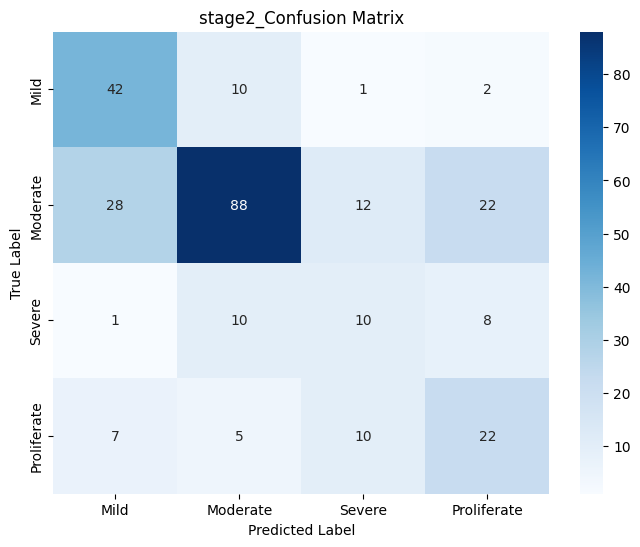

              precision    recall  f1-score   support

        Mild       0.54      0.76      0.63        55
    Moderate       0.78      0.59      0.67       150
      Severe       0.30      0.34      0.32        29
 Proliferate       0.41      0.50      0.45        44

    accuracy                           0.58       278
   macro avg       0.51      0.55      0.52       278
weighted avg       0.62      0.58      0.59       278



In [ ]:
import seaborn as sns
# 混淆矩陣
cm = confusion_matrix(y_val_true, y_val_pred)

# 顯示標籤名稱（可根據實際定義調整）
labels = ['Mild', 'Moderate', 'Severe', 'Proliferate']

# 畫圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('stage2_Confusion Matrix')
plt.show()

# 額外：顯示精確度、召回率等
print(classification_report(y_val_true, y_val_pred, target_names=labels))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 重設 test generator 狀態（保證預測對應）
test_gen_stage2.reset()

# 模型預測（softmax 輸出）
y_pred_probs = model_stage2.predict(test_gen_stage2, verbose=1)

# 取最大機率的類別
y_pred = np.argmax(y_pred_probs, axis=1)

# 取得真實標籤（flow_from_directory 已自動對應 label）
y_true = test_gen_stage2.classes


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


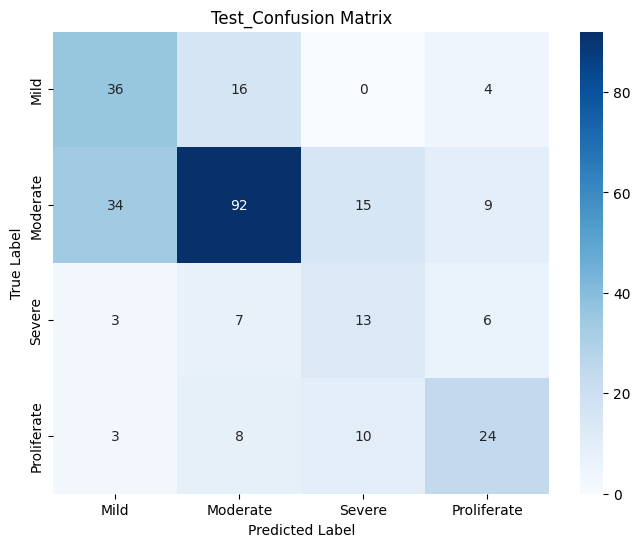

              precision    recall  f1-score   support

        Mild       0.47      0.64      0.55        56
    Moderate       0.75      0.61      0.67       150
      Severe       0.34      0.45      0.39        29
 Proliferate       0.56      0.53      0.55        45

    accuracy                           0.59       280
   macro avg       0.53      0.56      0.54       280
weighted avg       0.62      0.59      0.60       280



In [ ]:
# 顯示標籤名稱（根據資料夾順序）
class_names = list(test_gen_stage2.class_indices.keys())

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)
labels = ['Mild', 'Moderate', 'Severe', 'Proliferate']
# 繪圖
# 畫圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test_Confusion Matrix')
plt.show()

# 額外：顯示精確度、召回率等
print(classification_report(y_true, y_pred, target_names=labels))



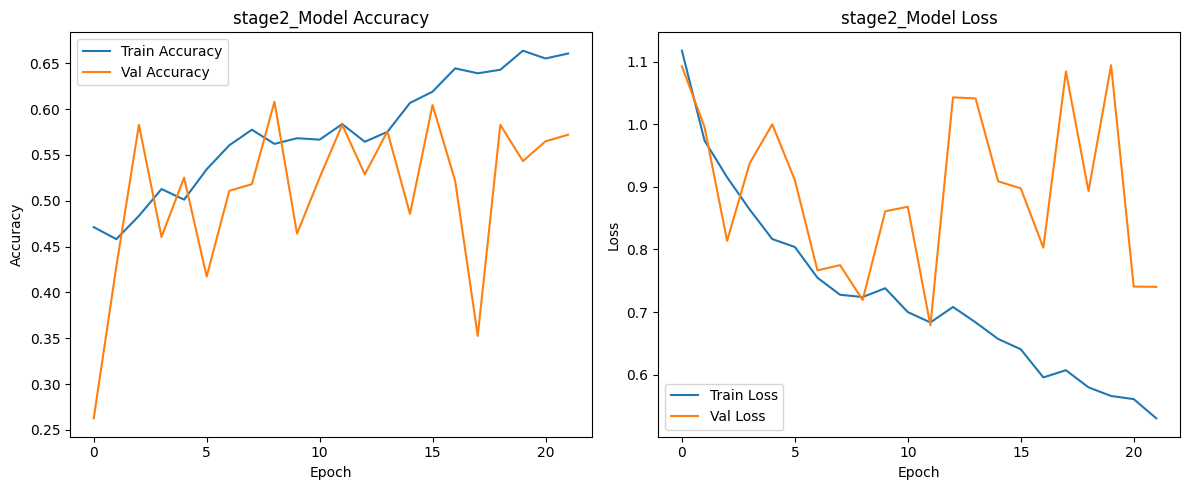

In [ ]:
# 畫 accuracy 與 loss 折線圖
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('stage2_Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('stage2_Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
